## Library Load

In [347]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd 
from copy import deepcopy 

## $ \hat m_{LLE}(x) = \frac{\sum w_i(x)Y_i}{\sum w_i(x)}$  
$ w_i(x) = k_i(\sum(k_jz_j^2  - z_i \sum k_jz_j)$

$ \text{first_term} = \sum k_jz_j^2 \quad $
$ \text{second_term} = \sum k_jz_j $

###  NW 와 LLE를 구현해 봤습니다.

In [348]:
def mat( matrix2 = None , Y =None , x = None ) :
    denominator = np.sum( matrix2 , axis =  1 ) 
    numerator   = np.dot(matrix2 , Y ) 
    m_hat = numerator/denominator
    dataframe = np.concatenate([x[:, np.newaxis ], m_hat[: , np.newaxis ]] , axis = 1 )
    pred = pd.DataFrame( dataframe , columns = ["x", "y_hat"]).sort_values(by = ["x"])
    return pred

def NW( x = None , data = None , Y = None , h = None , leave = False  ) : 
    # Gaussian Kernel 사용
    matrix = norm.pdf( (x[:, None] - data[None, :]) / h  , loc = 0 ,scale = 1) 
    """
    CV_LEAVE_ONE_OUT 할 때만 사용
    """
    if leave == True :
        matrix2 = deepcopy(matrix)
        np.fill_diagonal( matrix2 , 0 )
    else :
        matrix2 = matrix
    pred = mat( matrix2 , Y , x )
    return pred , matrix

"""
6장에서 5pg 를 참고해서 만들었습니다.
"""
def LLE(x = None , data =  None , Y = None , h = None , leave = False ) :
    """ z_matrix """
    z_mat  = x[:, None] - data[None, :]
    """ k_matrix """
    k_mat  = norm.pdf( (x[:, None] - data[None, :]) / h  ) 
    first_term = np.sum(k_mat *  np.square(z_mat)  , axis = 1 )
    second_term  = np.sum(k_mat * z_mat , axis = 1 ) 
    w_mat = k_mat * (first_term[: , None] - z_mat * second_term[: ,  None ])
    if leave == True :
        matrix2 = deepcopy(w_mat)
        np.fill_diagonal( matrix2 , 0 )
    else :
        matrix2 = w_mat
    
    pred = mat( matrix2 , Y , x)
    return pred , w_mat
    
def regressogram( X = None , y = None , num = None ) :
    grid = np.linspace(min(X), max(X) , num= 20)
    y_hat = []
    for i in range(len(grid)-1) :
        store = y[np.where( ( X >= grid[i]) & (X < grid[i+1]))]
        store2 = np.mean(store)
        y_hat.append( store2)
    OUTPUT = pd.DataFrame( {"grid" : grid[:-1] , "y_hat" : y_hat })
    return OUTPUT    
    

## CV 와 GCV를 구현해 봤습니다.

In [446]:

def cv(X = None , y = None , h= None) : 
    lle , w_mat = LLE(x = X , data =  X , Y =y , h = h ) 
    denominator = np.sum( w_mat , axis =  1 ) 
    numerator   = w_mat  
    numerator
    L = numerator / denominator[:, None]
    output = np.mean([  np.square((y[i] - lle.y_hat[i]) / (1 -  j )) for i , j in enumerate( np.diag(L))])
    
    return output


def gcv(X = None , y = None , h= None) : 
    lle , w_mat = LLE(x = X , data =  X , Y =y , h = h ) 
    denominator = np.sum( w_mat , axis =  1 ) 
    numerator   = w_mat  
    numerator
    L = numerator / denominator[:, None]
    nu = np.trace(L)
    output = np.mean( [np.square((y[i] - lle.y_hat[i]) / (1 -  nu/ len(X) )) for i  in range(len(X))  ])
    return output

### 1. $ Y = X^4 -5 X^3 + sin(x)^2 + sin(x) + eps $
$ \epsilon \sim N(0, 0.1^2) \quad\quad  X \sim N(0 , \sigma^2 )$

* Take  $  \sigma  = 1 $ Simulate n = 200 obesrvations , generate  $ (X_1 , Y_1)  , ... , (X_n , Y_n )$  from the model 
* suppose that you don't know the regression function and estimate it with Nadaraya-Waston estimator and local linear estimator. 
* For each method , consider cross-validation for chssing a proper bandwidth

### Repeat for $ \sigma = 0.4 $
###  Give your comments

In [350]:
def visualization( size_select = None , sigma = None , h_size = None , grid_size = None ) : 
    X  = np.random.normal( loc = 0 , scale = sigma , size= size_select )
    X = np.sort(X)
    eps = np.random.normal( loc = 0 , scale = 0.1 , size = size_select)
    y = pow(X, 4 ) - 5*pow(X, 2 ) +  np.square(np.sin(X) ) + np.sin(X) + eps 
    grid = np.linspace( np.min(X) , np.max(X) , grid_size )
    nw , _= NW( x = grid , data = X , Y = y , h = h_size )
    lle , _= LLE(x = grid , data =  X , Y =y , h = h_size ) 
    plt.scatter(X , y )
    plt.plot(X , y-eps ,  c = "k", label ="True")
    plt.plot(grid , nw.y_hat ,c = "c" , label = "NW")
    plt.plot(grid , lle.y_hat, c = "y" , label = "LLE")
    X1 = np.min(X) + h_size
    plt.vlines( X1 , np.min(y) , pow(X1, 4 ) - 5*pow(X1, 2 ) +  np.square(np.sin(X1) ) + np.sin(X1), colors = "r" , linewidth=1)
    X2 = np.max(X) - h_size
    plt.vlines( X2 , np.min(y) , pow(X2, 4 ) - 5*pow(X2, 2 ) +  np.square(np.sin(X2) ) + np.sin(X2) , colors = "r" , linewidth=1)
    plt.title("LLE , NW  / VISUALIZATION h_size = {} , sd = {}".format(h_size , sigma) , fontsize= 15)
    plt.text( np.median(X) , np.min(y) , "interior point ", fontsize=12 , fontdict = {"color" : "r"  })
    plt.hlines(y= np.min(y) , xmin= np.min(X) + h_size , xmax=np.max(X) - h_size , linewidth=1 , color='r')
    plt.legend()
    


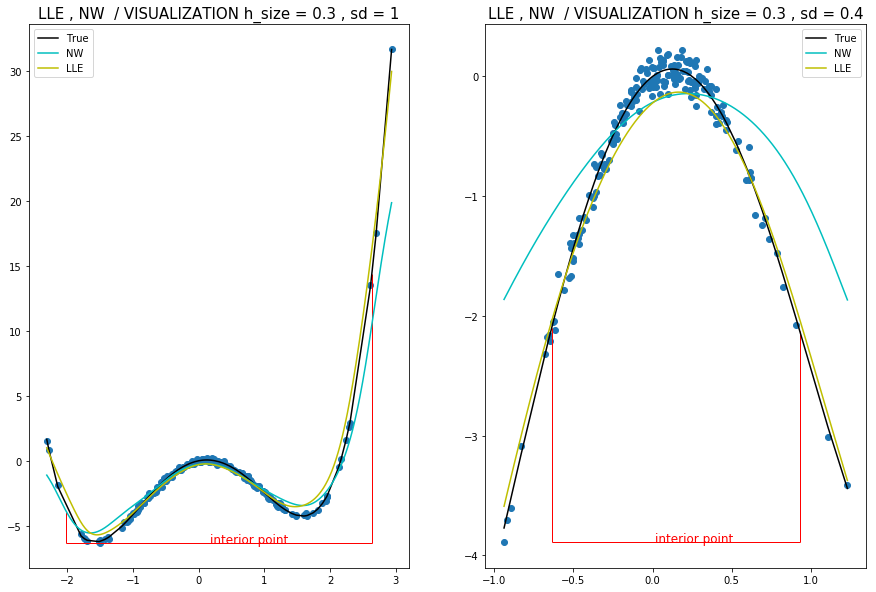

In [351]:

size_select = 200
sigma = 1
h_size = 0.3
grid_size = 1000

plt.figure(figsize=(15,10))
plt.subplot(121 )
visualization(size_select , sigma  , h_size , grid_size)
plt.subplot(122)
sigma = 0.4
visualization(size_select , sigma , h_size , grid_size)



## Comment
* 실제로 NW 와 LLE를 구현해서 시각화를 해봤더니  굴곡이 심한 곳에서는 interior point에서도 NW 와 LLE가 차이가 많이 나는 것을 확인 할 수 있었
고 , 특히 boundary point 일 경우 더 심하게차이가 나는 것을 확인 할 수 있었습니다.

## Cross Validation 을 시행했습니다.

In [352]:
%%time

sigma = 1 
X  = np.random.normal( loc = 0 , scale = sigma , size= size_select )
X = np.sort(X)
eps = np.random.normal( loc = 0 , scale = 0.1 , size = size_select)
y = pow(X, 4 ) - 5*pow(X, 2 ) +  np.square(np.sin(X) ) + np.sin(X) + eps 

grid = np.linspace(0.1 , 3  , 1000 )
cv2 = [ cv(X = X , y = y , h = i) for i in grid ]
cv_min = np.min( np.array(cv2)[~np.isnan(cv2)] )
h_min = grid[np.where( np.array(cv2) == cv_min)]


sigma = 0.4
X  = np.random.normal( loc = 0 , scale = sigma , size= size_select )
X = np.sort(X)
eps = np.random.normal( loc = 0 , scale = 0.1 , size = size_select)
y = pow(X, 4 ) - 5*pow(X, 2 ) +  np.square(np.sin(X) ) + np.sin(X) + eps 

grid = np.linspace(0.1 , 3  , 1000 )
cv2_1 = [ cv(X = X , y = y , h = i) for i in grid ]
cv_min2 = np.min( np.array(cv2_1)[~np.isnan(cv2_1)] )
h_min2 = grid[np.where( np.array(cv2_1) == cv_min2)]



/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


CPU times: user 2min 34s, sys: 9min 6s, total: 11min 41s
Wall time: 29.3 s


Text(0.5,1,'CV Sigma = 0.4 ')

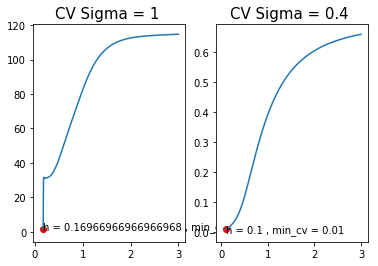

In [353]:
plt.subplot(121)
plt.plot(grid , cv2 )
plt.scatter(h_min , cv_min , marker = "o", color = "r")
a = "h = {} , min_cv = {}".format(h_min[0] , np.round(cv_min , 2 ) )
plt.text(h_min , cv_min - 0.2 , a )
plt.title("CV Sigma = 1 " , fontsize = 15)

plt.subplot(122)
plt.plot(grid , cv2_1 )
plt.scatter(h_min2 , cv_min2 , marker = "o", color = "r")
a = "h = {} , min_cv = {}".format(h_min2[0] , np.round(cv_min2 , 2 ) )
plt.text(h_min2 , cv_min2 - 0.01 , a )
plt.title("CV Sigma = 0.4 " , fontsize = 15)


## 적절한 bandwidth를 찾은 후에 시각화

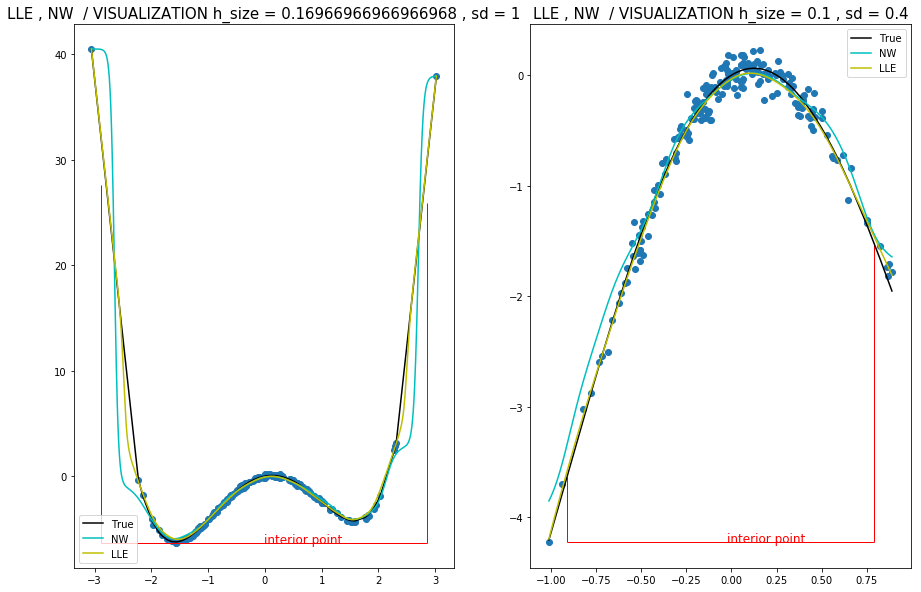

In [354]:
size_select = 200
grid_size = 1000
plt.figure(figsize=(15,10))
plt.subplot(121 )

sigma = 1
visualization(size_select , sigma  , h_min[0] , grid_size)
plt.subplot(122)
sigma = 0.4
visualization(size_select , sigma , h_min2[0] , grid_size)

## Motorcycle data 
$ X = time , Y = acceleration $

regressogram , kernel(NW) and Local Linear Regression

Use Cross validation to choose the smoothing parameter

In [807]:
data = pd.read_csv("./motor.txt", delimiter="\t")
data = data.sort_values(by=['times'])
data.columns

Index(['times', 'accel', 'strata', 'v'], dtype='object')

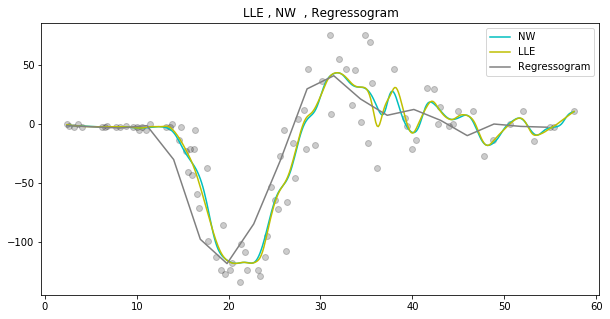

In [841]:
grid_size= 400
X = data.times.values
y = data.accel.values
h_size = 0.8
grid = np.linspace( np.min(X) , np.max(X) , grid_size )
nw , _= NW( x = grid , data = X , Y = y , h = h_size )
lle , _= LLE(x = grid , data =  X , Y =y , h = h_size ) 
plt.figure(figsize=(10,5))
plt.scatter(X , y , c = "k" , alpha = 0.2 )
plt.plot(grid , nw.y_hat ,c = "c" , label = "NW")
plt.plot(grid , lle.y_hat, c = "y" , label = "LLE")
regre = regressogram( X = X , y = y , num = 100)
plt.plot( regre.grid, regre.y_hat , c="grey", label ="Regressogram" )
plt.title( "LLE , NW  , Regressogram")
plt.legend()

## Cross Validation 과 GCV 시행

In [358]:
%%time 

grid_size= 400
X = data.times.values
y = data.accel.values


grid = np.linspace(0.1 , 4 , 1000 )
cv2 = [ cv(X = X , y = y , h = i) for i in grid ]
cv_min = np.min( np.array(cv2)[~np.isnan(cv2)] )
h_min = grid[np.where( np.array(cv2) == cv_min)]

grid = np.linspace(0.1 , 4 , 1000 )
gcv2 = [ gcv(X = X , y = y , h = i) for i in grid ]
gcv_min = np.min( np.array(gcv2)[~np.isnan(gcv2)] )
h_min2 = grid[np.where( np.array(gcv2) == gcv_min)]

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


CPU times: user 7.6 s, sys: 12.3 ms, total: 7.61 s
Wall time: 7.61 s


Text(0.5,1,'Generalized CV')

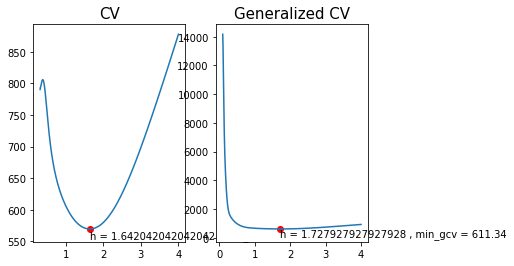

In [359]:
plt.subplot(121)
plt.plot(grid , cv2 )
plt.scatter(h_min , cv_min , marker = "o", color = "r")
a = "h = {} , min_cv = {}".format(h_min[0] , np.round(cv_min , 2 ) )
plt.text(h_min , cv_min - 15 , a )
plt.title("CV" , fontsize = 15)
##
plt.subplot(122)
plt.plot(grid , gcv2 )
plt.scatter(h_min2 , gcv_min , marker = "o" , color = "r")
a = "h = {} , min_gcv = {}".format(h_min2[0] , np.round(gcv_min , 2 ) )
plt.text(h_min2 , gcv_min - 500 , a )
plt.title("Generalized CV", fontsize = 15)

In [360]:
def visualization_2( X = None , y = None  , h_size = None , grid_size = None ) : 
    grid = np.linspace( np.min(X) , np.max(X) , grid_size )
    nw , _= NW( x = grid , data = X , Y = y , h = h_size )
    lle , _= LLE(x = grid , data =  X , Y =y , h = h_size ) 
    plt.scatter(X , y )
    plt.plot(grid , nw.y_hat ,c = "c" , label = "NW")
    plt.plot(grid , lle.y_hat, c = "y" , label = "LLE")
    plt.title("LLE , NW  / VISUALIZATION h_size = {} ".format(h_size[0]) , fontsize= 15)
    plt.legend()

Text(10,50,'GCV')

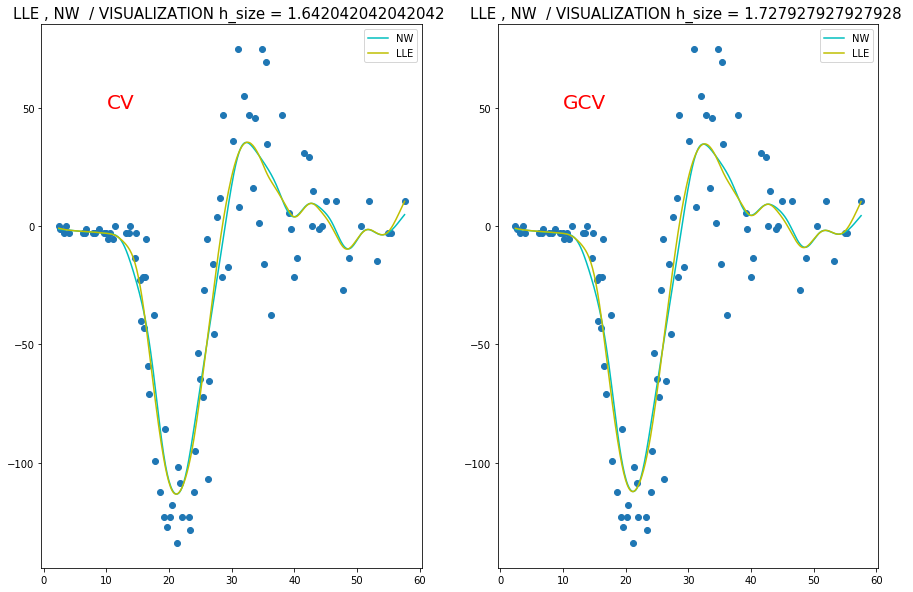

In [367]:
grid_size= 400
X = data.times.values
y = data.accel.values
plt.figure(figsize=(15,10))
plt.subplot(121)
visualization_2( X , y , h_min , grid_size = 400 )
plt.text(10, 50 , "CV" , fontsize = 20 , color ="red")
plt.subplot(122)
visualization_2( X , y , h_min2 , grid_size = 400 )
plt.text(10, 50 , "GCV", fontsize = 20 , color ="red")

## Comment
* CV 와 GCV를 활용하여서 가장 최적의 H를 찾아봤을 때 값으로는 대략 0.1 정도의 차이가 나게 나왔습니다.


# 3번
$$ Y = 0.1 X^2 - Sin(2X) + \frac{1}{2}Cos(7X) + \epsilon \\  X \sim  exp( \lambda = 0.25 ) \quad\quad  \epsilon \sim N(0 , 0.1^2 )$$

 
 * eps = 0.5 로 하면 좋은 형태의 그림이 안나와서 0.5 => 0.1 로 해서 진행함
 * 일단 최적의 h 를 찾기로 했습니다.

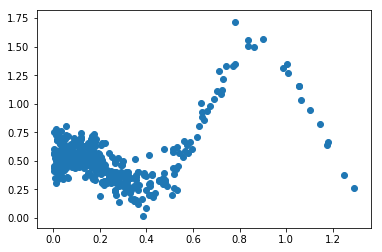

In [735]:
size_select = 400
X = np.random.exponential( scale = 0.25 , size = size_select )
X = np.sort(X)
eps = np.random.normal( loc = 0,  scale = 0.1 , size = size_select )

def f(X= None) : 
    y = 0.1 * np.power(X, 2 )+  np.sin( 2 * X) +  1/2 * np.cos( 7*X) 
    return y

y =  f(X)+eps

plt.scatter(X , y )

Text(0.0435176,0.0106463,'h = 0.043517587939698496 , min_gcv = 0.01')

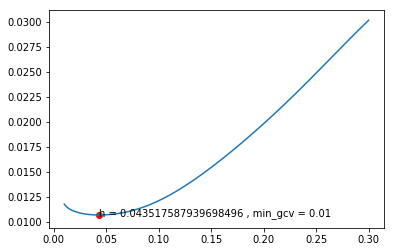

In [736]:
grid = np.linspace(0.01 , 0.3 , 200 )
gcv2 = [ gcv(X = X , y = y , h = i) for i in grid ]
gcv_min = np.min( np.array(gcv2)[~np.isnan(gcv2)] )
h_min2 = grid[np.where( np.array(gcv2) == gcv_min)]
plt.plot(grid , gcv2 )
plt.scatter(h_min2 , gcv_min , marker = "o" , color = "r")
a = "h = {} , min_gcv = {}".format(h_min2[0] , np.round(gcv_min , 2 ) )
plt.text(h_min2 , gcv_min - 0.00005 , a )

Text(0.4,1.5,'GCV')

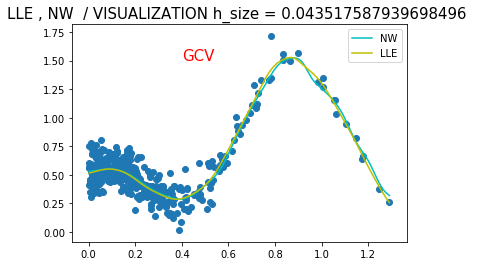

In [737]:
visualization_2( X , y , h_min2 , grid_size = 200 )
plt.text(0.4 , 1.5 , "GCV" , fontsize= 15 , color ="red")

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


Text(0.040603,0.0105212,'h = 0.040603015075376885 , min_cv = 0.01')

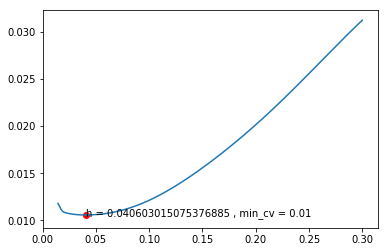

In [738]:
grid = np.linspace(0.01 , 0.3 , 200 )
cv2 = [ cv(X = X , y = y , h = i) for i in grid ]
cv_min = np.min( np.array(cv2)[~np.isnan(cv2)] )
h_min = grid[np.where( np.array(cv2) == cv_min)]
plt.plot(grid , cv2 )
plt.scatter(h_min , cv_min , marker = "o" , color = "r")
a = "h = {} , min_cv = {}".format(h_min[0] , np.round(cv_min , 2 ) )
plt.text(h_min , cv_min - 0.00005 , a )

Text(0.4,1.5,'CV')

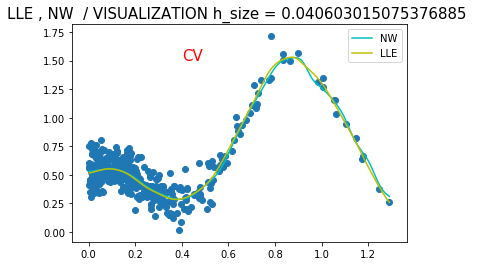

In [739]:
visualization_2( X , y , h_min , grid_size = 200 )
plt.text(0.4 , 1.5 , "CV" , fontsize= 15 , color ="red")

In [681]:
X[np.where(X < 0.001)]

array([0.00077737])

In [742]:
np.where((X > 0.199999) & (X < 0.2001))
np.where((X > 0.39999) & (X < 0.4025))
np.where((X > 0.595) & (X < 0.600001))
np.where((X > 0.79) & (X < 0.80901))
np.where((X > 0.99) & (X < 1.001))


(array([], dtype=int64),)

# Comment 
* MSE 를 구하기 전에 최적에 h 를 찾아보니 0.042222정도가 나왔습니다.
* NW 보다 LLE가 추정을 더 잘한 것으로 보인다.
* 이 그림만 봤을 때도 우리가 사전에 알고 있던  boundary point 부분에서 NW 의 mse가 더 높을 것 같다는 생각을 해볼 수 있다.


Size = 100 Estimate $$ MSE(\hat m_{nw}(x)) \quad MSE(\hat m_{LLE}(x)) \quad for \quad  x = 0 , 0.2 , 0.4 , 0.6 , 0.8 , 1.0 $$ by simulation many samples from the model 

In [802]:
index_ = [
    np.where(X < 0.00255) , 
    np.where((X > 0.199) & (X < 0.2001)) , 
    np.where((X > 0.399) & (X < 0.4025)) ,
    np.where((X > 0.59) & (X < 0.600001)) , 
    np.where((X > 0.7815) & (X < 0.800001)) ,
    np.where((X > 0.99999) & (X < 1.0059))
        ]



index_ = np.squeeze(index_)

for i , j in zip(index_, see) : 
    X[i] = j  
    
print(index_)

[  0 221 327 365 383 389]


* Comment : 실제 0 , 0.2 , 0.4, 0.6 , 0.8 , 1.0 이 나오지 않기 때문에 바꿔주는 작업을 진행했습니다.

In [804]:
%%time

see = [0 , 0.2 , 0.4 , 0.6 , 0.8 , 1.0]

NW_MSE = []
LLE_MSE = []
for i , j in enumerate(see) :
    nw_blank = []
    lle_blank = []
    for _ in range(1000) :
        y =  f(X)
        nw , _  = NW( x = X , data = X , Y = y , h = h_min2 )
        lle , _ = LLE(x = X , data =  X , Y =y , h = h_min2 )
        
        nw_output  = np.square(y[index_[i] ] - nw.y_hat[index_[i] ])
        lle_output = np.square(y[index_[i] ] - lle.y_hat[index_[i] ])
        nw_blank.append(nw_output)
        lle_blank.append(lle_output)
    
    nw_mse  = np.mean(nw_blank)
    lle_mse = np.mean(lle_blank)
    NW_MSE.append(nw_mse)
    LLE_MSE.append(lle_mse)
    
    print("{} 번째 , X = {} 끝남".format(i+1 , j ))

1 번째 , X = 0 끝남
2 번째 , X = 0.2 끝남
3 번째 , X = 0.4 끝남
4 번째 , X = 0.6 끝남
5 번째 , X = 0.8 끝남
6 번째 , X = 1.0 끝남
CPU times: user 21min 15s, sys: 1h 16min 7s, total: 1h 37min 23s
Wall time: 4min 3s


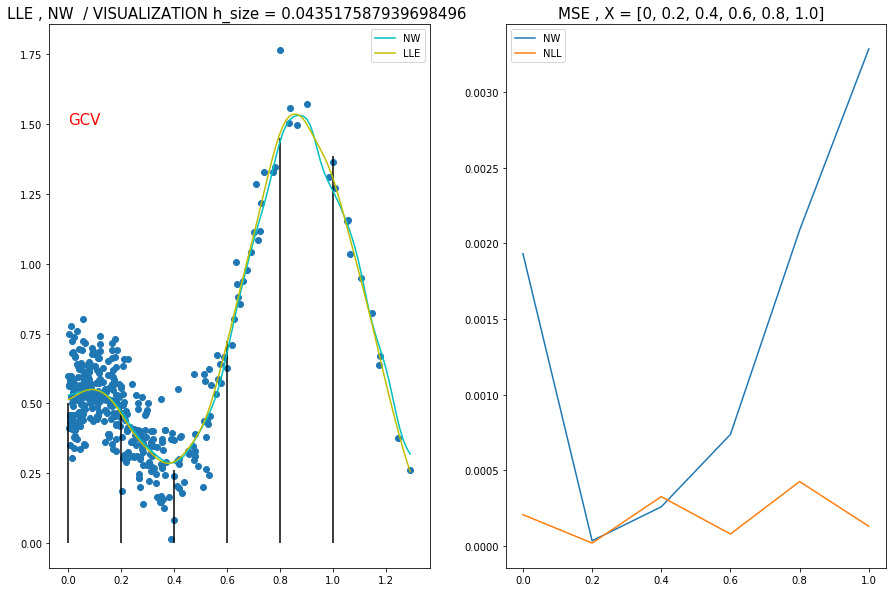

In [806]:
plt.figure(figsize = (15,10))
plt.subplot(121)
visualization_2( X , y + eps , h_min2 , grid_size = 100 )
plt.text(0.0 , 1.5 , "GCV" , fontsize= 15 , color ="red")
plt.vlines(x = 0   , ymin=0 , ymax= f(0) )
plt.vlines(x = 0.2 , ymin=0 , ymax= f(0.2))
plt.vlines(x = 0.4 , ymin=0 , ymax= f(0.4))
plt.vlines(x = 0.6 , ymin=0 , ymax= f(0.6))
plt.vlines(x = 0.8 , ymin=0 , ymax= f(0.8))
plt.vlines(x = 1.0 , ymin=0 , ymax= f(1.0))
plt.subplot(122)
plt.plot( see , NW_MSE  , label ="NW")
plt.plot( see , LLE_MSE , label ="NLL")
plt.title("MSE , X = {}  ".format(see) , fontsize= 15)
plt.legend()

## Comment
* X = 0 (Boundary Point)
    * 추정값을 확인해보면 NW 보다 LLE 가 좀 더 Boundary 부분에서 잘 추정 된 것을 확인 할 수 있고 실제 $ MSE_{NLL}(X=0) < MSE_{NW}(X=0)$ 인 것이 확인이 되었습니다. 그래서 우리가 이론적으로 알고 있었던 부분과 일치하는 것을 확인 할 수 있었습니다.
    
* X = 0.2 ,0.4 ,0.6 
    * Boundary 부분이 아니라서 MSE값이 상대적으로 덜 차이 나는 것을 확인 할 수 있었습니다.
    
* X = 0.8 , 1 
    * Boundary 부분을 확인하는 이유는 그 부분에 데이터가 다른 곳에 비해 적어서 확인을 해보는 건데 마찬가지로 X=1 인 부분에서도 데이터가 적기 때문에 NLL 가 NW 에서 차이가 많이 나는 것을 확인 할 수 있었습니다.

## Loess 구현 실패작
* 어쩌다 하다보니 KNN Regression 같은 모양이 되어버림

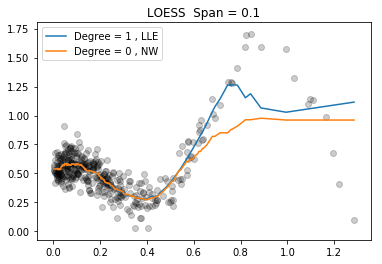

In [422]:
f = 0.1
plt.scatter(X ,y , c = "k", alpha = 0.2)
grid , y1 = loess(  X =X , Y = y , f = f , degree= 1 )
plt.plot(grid , y1  , label ="Degree = 1 , LLE")
grid , y2 = loess(  X =X , Y = y , f = f , degree= 0)
plt.plot(grid , y2  , label ="Degree = 0 , NW")
plt.title("LOESS  Span = {}".format(f))
plt.legend()

In [10]:
"""
tricube function은 어디다가 넣어야하지....
w 가중치 부분(tricube_kernel)이 있는 것 같은데 어디다가 넣어야하지...
잘못된 구현을 한 것 같다.
"""

def loess(  X = None , Y = None , f = None , degree =None) :
#     grid = np.linspace( min(X) , max(X) , grid_count)
#     n2 = len(grid)
    n2 = len(X)
    r = int(np.ceil(f * n2))
    h = [np.sort(np.abs( X-X[i]))[:r] for i in range(n2) ]
    d = [ np.abs( X -X[i]) for i in range(n2)]
    grid1 = [ X[np.isin(d[i] , h[i])] for i in range(len(d))]
    y = [ Y[np.isin(d[i] , h[i])] for i in range(len(d))]
    """
    x-x_i 부분 매트릭스
    """
    grid2 = grid1
    
    y_store = []
    poly_degree = degree
    
    for i , grid2 in enumerate(grid2) : 
        
        a = grid2
        xcols = [np.ones_like(a)]
        for j in range(1, (poly_degree + 1)):
            xcols.append([k ** j for k in a ])
        x1 = np.vstack(xcols).T
        d = np.linalg.inv( x1.T @ x1 ) @ x1.T @ y[i]    
        d1 = np.squeeze(d)
                
        if np.shape(d1) == ()  : 
            yest = d1
        else :
            yest = d1[0]    
            for term in np.arange(1,len(d1)) :
                yest += d1[term] * X[i]
        
        y_store.append( yest )   
        
    return X , y_store


sigma = 1
X  = np.random.normal( loc = 0 , scale = sigma , size= size_select )
X = np.sort(X)

eps = np.random.normal( loc = 0 , scale = 0.1 , size = size_select)
y = pow(X, 4 ) - 5*pow(X, 2 ) +  np.square(np.sin(X) ) + np.sin(X) + eps 
plt.scatter(X ,y , c = "k", alpha = 0.2)
grid , y1 = loess(  X =X , Y = y , f = 0.1 , degree= 1 )
plt.plot(grid , y1  , label ="LLE")
grid , y2 = loess(  X =X , Y = y , f = 0.1 , degree= 0)
plt.plot(grid , y2  , label ="NW")
plt.legend()    

데이터 자체가 낮은 쪽에 쏠려있어서 LOESS를 사용하면 비율을 0.1로 잡아도 뭉쳐있는 쪽에 데이터를 사용해서 데이터가 드문 곳에서는 잘 추정을 못하는 듯함 그림을 보여준다.

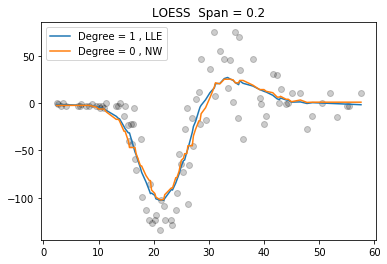

In [356]:
X = data.times.values
y = data.accel.values
f = 0.2
plt.scatter(X ,y , c = "k", alpha = 0.2)
grid , y1 = loess(  X =X , Y = y , f = f , degree= 1 )
plt.plot(grid , y1  , label ="Degree = 1 , LLE")
grid , y2 = loess(  X =X , Y = y , f = f , degree= 0)
plt.plot(grid , y2  , label ="Degree = 0 , NW")
plt.title("LOESS  Span = {}".format(f))
plt.legend()


